In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import sys

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import sys
from scipy import signal

resampling = 'resampled'
depth_list = ['GM']
nruns = 4
subject = 'sub-46'
session = '02'
task = 'RET'


# For me it is only one depth = GM 
for depth in range(len(depth_list)):
    proc_tc_RH = [] # Store the time course form the Right Hemisphere
    proc_tc_LH = [] # Store the time course form the Left Hemisphere

    for run in range(nruns): # Approximately 4 runs 
        # Load GIFTI files for left and right hemispheres
        proc_tc_L = nib.load(
            f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-L_desc-{denoising}_bold_GM.gii')
        proc_tc_R = nib.load(
            f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-R_desc-{denoising}_bold_GM.gii')

        # Aggregate the data for the hemisphere separately 
        tc_R = proc_tc_R.agg_data().T  # (time points, vertices)
        tc_L = proc_tc_L.agg_data().T  # (time points, vertices)
        print(tc_R.shape)
        # Not needed now 
        #if tc_R.shape[0] > 136:
        #    tc_R = tc_R[:136, :]
        #    print(tc_R.shape)
        #if tc_L.shape[0] > 136:
        #    tc_L = tc_L[:136, :]

        # Normalize 
        tc_m_R = tc_R * np.expand_dims(np.nan_to_num((100 / np.mean(tc_R, axis=0))), axis=0)
        tc_m_L = tc_L * np.expand_dims(np.nan_to_num((100 / np.mean(tc_L, axis=0))), axis=0)

        # Baseline correction
        baseline_R = np.median(tc_m_R[:5], axis=0)
        baseline_L = np.median(tc_m_L[:5], axis=0)

        tc_m_R = tc_m_R - baseline_R
        tc_m_L = tc_m_L - baseline_L

        # Filter if enabled
        if filter == 1:
            mean_R = np.mean(tc_m_R, axis=0)
            mean_L = np.mean(tc_m_L, axis=0)

            tc_m_R = signal.detrend(tc_m_R, axis=0) + mean_R
            tc_m_L = signal.detrend(tc_m_L, axis=0) + mean_L

            # Highpass-filtering
            TR = 1.5
            fs = 1 / TR
            lowcut = 0.006
            nyquist = 0.5 * fs
            f_low = lowcut / nyquist
            sos = signal.butter(8, [f_low], 'highpass', fs=fs, output='sos')
            tc_m_R = signal.sosfiltfilt(sos, tc_m_R, axis=0)
            tc_m_L = signal.sosfiltfilt(sos, tc_m_L, axis=0)

        # Store processed data for saving
        proc_tc_RH.append(tc_m_R)
        proc_tc_LH.append(tc_m_L)

    # Compute median time course across runs
    mean_proc_tc_RH = np.median(np.array(proc_tc_RH), axis=0)
    mean_proc_tc_LH = np.median(np.array(proc_tc_LH), axis=0)

    # Save the processed time courses for RH and LH separately
    path = f'{MAIN_PATH}/pRFM/{subject}/ses-{session}/{denoising}/'
    os.makedirs(path, exist_ok=True)
    np.save(f'{path}{subject}_ses-{session}_task-{task}_hemi-rh_desc-avg_bold_GM.npy', mean_proc_tc_RH)
    np.save(f'{path}{subject}_ses-{session}_task-{task}_hemi-lh_desc-avg_bold_GM.npy', mean_proc_tc_LH)

In [4]:
MAIN_PATH = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives'
subject = 'sub-46'
session = '02'
denoising = 'nordic'
depth_list = 'GM'
nruns = 4
resampling = 'resampled'
task = 'RET'

for depth in range(depth_list.__len__()):
    proc_tc_L = []
    proc_tc_R = []
    proc_tc = []
    for run in range(nruns):
        proc_tc_L = nib.load(
            f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-L_desc-{denoising}_bold_GM.gii')
        proc_tc_R = nib.load(
            f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-R_desc-{denoising}_bold_GM.gii')
        tc = np.vstack([proc_tc_L.agg_data(), proc_tc_R.agg_data()]).T
        if tc.shape[0]>136:
            tc=tc[:,:] 
        tc=tc[:,:] 
        tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0) 

        # Baseline correction
        baseline = np.median(tc_m[:5], axis=0)
        tc_m = tc_m - baseline # ORIGINAL TIME COURSE

        if filter==1:
            from scipy import signal
            mean=np.mean(tc_m, axis=0) # Remove linear trend without demeaning
            tc_m=signal.detrend(tc_m, axis=0)+mean
            # Highpass-filtering
            TR = 1.5                                                            ## TR is the time between successive MRI scans, measured in seconds.                              
            fs = 1 / TR  # Hz                                                   ## FS is the sampling frequency, which is the number of samples per second. It's the inverse of the TR.
            lowcut=0.006 # cut-off freq of the filter                            ## Lowcut and highcut define the frequency range for the high-pass filter. Only the lowcut frequency is used.
            highcut=0.015 # cut-off freq of the filter
            nyquist=0.5*fs                                                      ## Nyquist frequency is half the sampling frequency.
            f_low = lowcut/nyquist;                                             ## The cut-off frequencies are normalized. (e.i 0,02 )
            f_high = highcut/nyquist;
            sos = signal.butter(8, [f_low],'highpass', fs=fs,output='sos')      ## Azzurra used low-pass 4th order Butterworth filter with a cut-off frequency of 0.1 Hz
            tc_m = signal.sosfiltfilt(sos, tc_m, axis=0)

        proc_tc.append(tc_m)
    mean_proc_tc = np.median(np.array(proc_tc), axis=0)
    psc = (mean_proc_tc) # FILTERED TIME COURSE

    path=f'{MAIN_PATH}/pRFM/{subject}/ses-{session}/{denoising}/'
    os.makedirs(path, exist_ok=True)
    np.save(f'{MAIN_PATH}/pRFM/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_hemi-LR_desc-avg_bold_{depth_list[depth]}_trial.npy',psc)

/var/folders/0k/zjsxn2197mdbzvx14lj8m0v00000gn/T/ipykernel_63170/1011283980.py:23: RuntimeWarning: divide by zero encountered in divide
  tc_m = tc * np.expand_dims(np.nan_to_num((100 / np.mean(tc, axis=0))), axis=0)


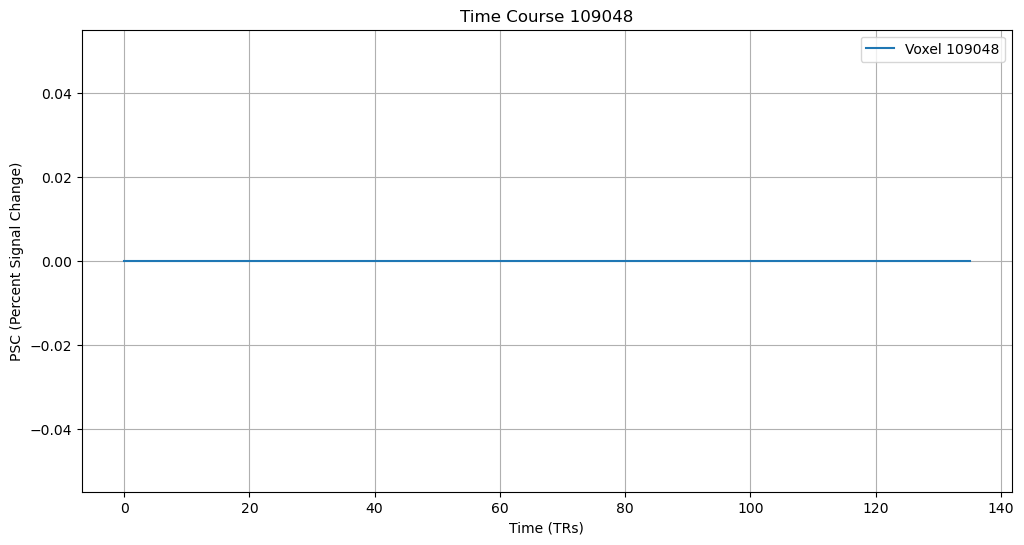

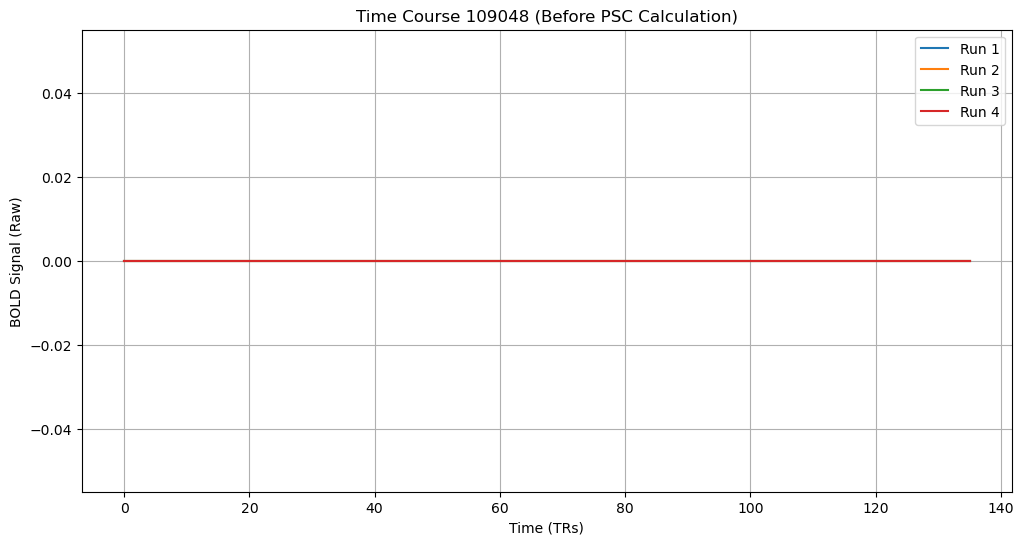

In [24]:
# 1. PLOT THE TIME COURSE AFTER THE PSC CALCULATION
psc_path = f'{MAIN_PATH}/pRFM/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_hemi-LR_desc-avg_bold_{depth_list[depth]}_trial.npy'
psc_data = np.load(psc_path)

voxel_tc = psc_data[:, 109048]
plt.figure(figsize=(12, 6))
plt.plot(voxel_tc, label='Voxel 109048')
plt.title(f'Time Course 109048')
plt.xlabel('Time (TRs)')
plt.ylabel('PSC (Percent Signal Change)')
plt.grid(True)
plt.legend()
plt.show()

# 2. PLOT THE TIME COURSE BEFORE THE PSC CALCULATION
voxel_tc_raw = []
# Load data from the .gii files
for run in range(nruns):
    proc_tc_L = nib.load(f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-L_desc-{denoising}_bold_GM.gii')
    proc_tc_R = nib.load(f'{MAIN_PATH}/{resampling}/{subject}/ses-{session}/{denoising}/{subject}_ses-{session}_task-{task}_run-{run + 1}_space-fsnative_hemi-R_desc-{denoising}_bold_GM.gii')
    tc = np.vstack([proc_tc_L.agg_data(), proc_tc_R.agg_data()]).T  # Combine left and right hemisphere data
    voxel_tc_raw.append(tc[:, 109048])  

voxel_tc_raw = np.array(voxel_tc_raw)
plt.figure(figsize=(12, 6))
for i, run_data in enumerate(voxel_tc_raw):
    plt.plot(run_data, label=f'Run {i + 1}')
plt.title(f'Time Course 109048 (Before PSC Calculation)')
plt.xlabel('Time (TRs)')
plt.ylabel('BOLD Signal (Raw)')
plt.grid(True)
plt.legend()
plt.show()

46 69 -2
Extracted Signals: [[20.87963933 21.16020807 20.57149437 20.07140338 20.44788429 20.78957852
  21.54092725 21.52455584 21.00353834 21.86391693 21.55200163 21.19128021
  21.10772891 21.66054756 20.98357801 20.98490622 20.93437093 21.1991374
  21.2734753  21.30188998 21.4732978  21.12746104 22.92916776 21.18622577
  21.8524603  21.21518105 22.08883401 21.7856286  22.47759091 21.30958329
  21.82578193 21.54235205 20.44382057 22.40171774 22.38290434 21.2967407
  21.59283178 23.69555862 21.37679127 21.79168608 21.49667866 22.21738679
  22.42974348 21.71432768 21.76059072 22.16194669 21.27566268 21.5634486
  21.9569479  21.25963044 22.89116357 22.48259616 21.46117998 21.89097669
  22.83285848 20.00735461 21.17408526 22.72607889 21.10996379 21.10725268
  22.84392895 21.11287684 21.48929124 23.07828044 20.63451977 21.07283436
  22.15137996 21.49191048 20.6965012  23.06337927 20.27521024 20.70871629
  21.7070559  20.74040778 20.19549426 22.1357907  20.61566407 21.18215594
  21.04474972

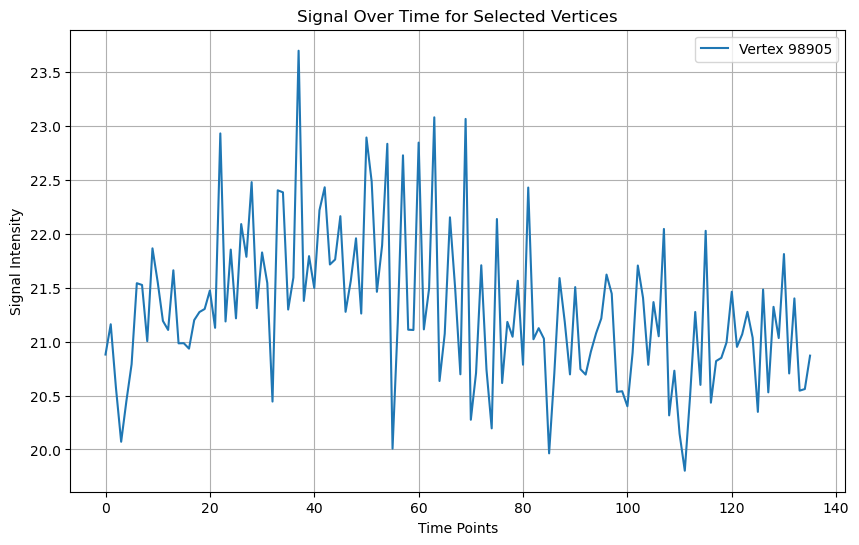

In [22]:
import nibabel.freesurfer.io as fs

nifti_file = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/sub-46/ses-02/func/sub-46_ses-02_task-RET_run-1_bold.nii.gz'
img = nib.load(nifti_file)
data = img.get_fdata()
vertex_indices = np.array([98905])

surface_file = '/Volumes/FedericaCardillo/pre-processing/projects/PROJECT_EGRET-AAA/derivatives/freesurfer/sub-46/surf/lh.white'  # Change accordingly
coords, faces = fs.read_geometry(surface_file)

affine = img.affine

# Convert surface coordinates to voxel indices
def world_to_voxel(coords, affine):
    coords = np.hstack([coords, np.ones((coords.shape[0], 1))])
    voxel_coords = np.linalg.inv(affine).dot(coords.T).T[:, :3]
    return np.round(voxel_coords).astype(int)

voxel_indices = world_to_voxel(coords[vertex_indices], affine)

signals = []
for voxel in voxel_indices:
    x, y, z = voxel
    signals.append(data[x, y, z])
print(x, y, z)

signals = np.array(signals)
print("Extracted Signals:", signals)

# Plot each signal over time
time_points = np.arange(signals.shape[1])

plt.figure(figsize=(10, 6))
for i, signal in enumerate(signals):
    plt.plot(time_points, signal, label=f'Vertex {vertex_indices[i]}')

plt.title('Signal Over Time for Selected Vertices')
plt.xlabel('Time Points')
plt.ylabel('Signal Intensity')
plt.legend()
plt.grid()
plt.show()